In [40]:
import nbimporter
from data_cleaning_standardization_01 import *
from mordred_descriptors_creation_02 import *
from mordred_fingerprints_svm_03 import *

In [41]:
import joblib
from mordred import Calculator, descriptors

model_data = joblib.load('svm_mordred_model.pkl')
svm_model = model_data['model']
scaler = model_data['scaler']
feature_names = model_data['feature_names']
standardize_molecule = model_data['standardization_function']

calc = Calculator(descriptors, ignore_3D=True)

def test_on_new_data(file_path, dataset_name):
    print(f"\nTesting {dataset_name}...")

    # Load and process
    new_df = pd.read_csv(file_path)
    new_df['clean_smiles'] = new_df['SMILES'].apply(standardize_molecule)
    new_df = new_df.dropna(subset=['clean_smiles']) # Drop rows where standardization failed

    # Generate descriptors
    mols_new = [Chem.MolFromSmiles(smi) for smi in new_df['clean_smiles']]
    descriptors_new = calc.pandas(mols_new)

    # Convert all descriptor columns to numeric, coercing errors to NaN
    descriptors_new = descriptors_new.apply(pd.to_numeric, errors='coerce')

    # Reindex to ensure feature presence and order match the training data X
    # Any descriptor column present in X.columns but not in descriptors_new will be added with NaN
    # Any descriptor column in descriptors_new but not in X.columns will be dropped
    X_new_aligned = descriptors_new.reindex(columns=X.columns)

    X_new = X_new_aligned.fillna(0)

    # Predict
    predictions = svm_model.predict(scaler.transform(X_new))

    # Evaluation metrics
    mae = mean_absolute_error(new_df['LogS'], predictions)
    r2 = r2_score(new_df['LogS'], predictions)

    print(f"   MAE: {mae:.3f} LogS units")
    print(f"   R²:  {r2:.3f}")

    # visualization
    plt.figure(figsize=(6, 5))
    plt.scatter(new_df['LogS'], predictions, alpha=0.6, s=30)
    plt.plot([new_df['LogS'].min(), new_df['LogS'].max()],
             [new_df['LogS'].min(), new_df['LogS'].max()], 'r--', linewidth=2)
    plt.xlabel('Experimental LogS')
    plt.ylabel('Predicted LogS')
    plt.title(f'{dataset_name}\nMAE = {mae:.3f}, R² = {r2:.3f}')
    plt.grid(True, alpha=0.3)
    plt.show()

    return mae, r2



Testing Dataset 1...
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
   MAE: 0.848 LogS units
   R²:  -0.136


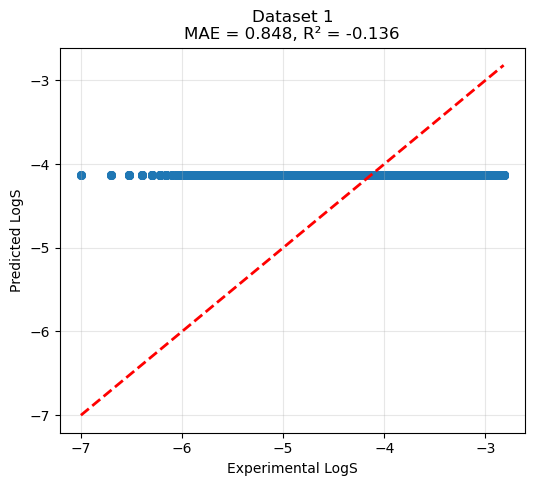


Testing Dataset 2...
/home/zenab-khan/miniconda3/envs/CADDSeminar/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
   MAE: 3.103 LogS units
   R²:  -19.123


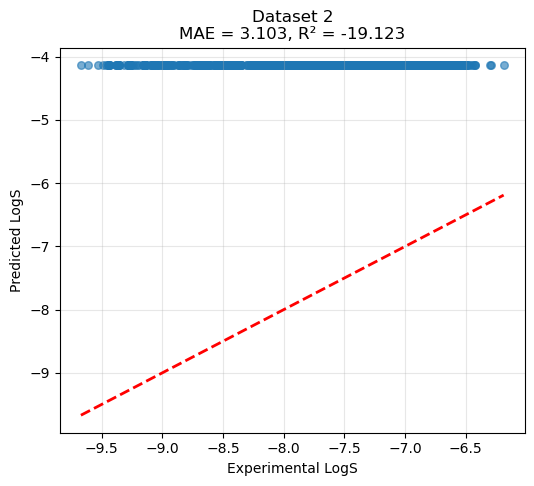

In [42]:
mae1, r21 = test_on_new_data("./data/challenge_data_1.csv", "Dataset 1")
mae2, r22 = test_on_new_data("./data/challenge_data_2.csv", "Dataset 2")